# FEDOT framework
#### FEDOT version = 0.7.2

In [1]:
!pip install fedot==0.7.2

In [2]:
import logging
# set DEBUG for everything
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
# set WARNING for Matplotlib
logger.setLevel(logging.WARNING)

Below is a description of the FEDOT framework and its main functions, which can be used to solve various ML tasks, namely:

* Regression
* Classification
* Time series forecasting
* Clustering

FEDOT can construct complex composite models (consisting of multiple machine learning models and preprocessing operations) based on an evolutionary algorithm. Thus, it is possible to create pipelines for solving various tasks.

The structure of the FEDOT framework can be seen in the figure below:

<img src="../jupyter_media/fedot_structure/fedot_structure_04.png" width="800"/> 

Figure 1. The structure of the FEDOT framework. The main modules of the library are shown.

As you can see from the picture there are two ways to start FEDOT:
1) API - allows you to run framework models in a few lines of code;
2) Low-level methods from the core - you can call methods by accessing the core directly. In this case, you will have to write more code, but more functionality opens up.

## Composite models

FEDOT has following abstractions:
* Operation - is a machine learning model or preprocessing operation or statistical models;
* Node - is a container in which the operation is placed. A single node can contain only one operation;
* Pipeline - is directed acyclic graph-like structure that contains several connected nodes. The analogue can be a computation graph from tensorflow, or simple workflow (from Apache Airflow, for instance). Pipelines are complex composite models. A single pipeline can consist of multiple nodes, or a single node.

<img src="../jupyter_media/fedot_structure/operation_node_pipeline.png" width="800"/> 

## Generate synthetic dataset for classification task

In [3]:
import logging
logging.raiseExceptions = False

from fedot.utilities.synth_dataset_generator import classification_dataset
from sklearn.metrics import roc_auc_score as roc_auc

# Generate numpy arrays with features and target
features_options = {'informative': 1, 'redundant': 0,
                    'repeated': 0, 'clusters_per_class': 1}
x_data, y_data = classification_dataset(samples_amount=250,
                                        features_amount=3,
                                        classes_amount=2,
                                        features_options=features_options)

print(f'Features table shape: {x_data.shape}, type: {type(x_data)}')
print(f'Target vector: {y_data.shape}, type: {type(y_data)}')

Features table shape: (250, 3), type: <class 'numpy.ndarray'>
Target vector: (250,), type: <class 'numpy.ndarray'>


Prepare the necessary imports

In [4]:
import numpy as np

# Create pipelines
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

## Manual pipeline 

Below, we will try to set the pipeline manually, and obtain a prediction using it.

Manually create a pipeline with the following configuration:

![logit_scaling_lda.png](../jupyter_media/fedot_structure/logit_scaling_lda.png)

In [5]:
# Define pipeline 
node_logit = PrimaryNode('logit')
node_scaling = PrimaryNode('scaling')
node_logit = SecondaryNode('lda', nodes_from=[node_logit, node_scaling])
pipeline = Pipeline(node_logit)

# Fit it
pipeline.fit(input_data)

# Make prediction
predicted_output = pipeline.predict(input_data)
probs = np.array(predicted_output.predict)

# Check metric value
print(f'ROC AUC score on training sample: {roc_auc(y_data, probs):.3f}')

d:\anaconda_envs\.conda\envs\examples\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
d:\anaconda_envs\.conda\envs\examples\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
d:\anaconda_envs\.conda\envs\examples\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
d:\anaconda_envs\.conda\envs\examples\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use InverseSquared instead. The inverse_squared link alias will be removed 

ROC AUC score on training sample: 0.945


This is how you learned the concept of pipelines in FEDOT.

But FEDOT can automatically construct such pipelines to solve the task.

Below are two examples for solving the classification task (with such pipelines) using API methods and using FEDOT.core function directly. Both examples, regardless of the way they interact, run an automatic machine learning algorithm.

## AutoML

### API example

Using the API allows you to find good solutions using a few lines of code, but on the other hand, this approach has less abilities for modification than using core-based methods.

In [6]:
from fedot.api.main import Fedot

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', 
                    timeout=1, preset='fast_train',
                    seed=20, logging_level=0)

# During fit, the pipeline composition algorithm is started
pipeline = fedot_model.fit(features=x_data,
                           target=y_data)

d:\anaconda_envs\.conda\envs\examples\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:AssumptionsHandler - Initial pipeline fitting started


2023-10-02 19:35:43,211 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:35:43,220 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:35:43,224 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:35:43,226 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:35:43,774 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:35:43,781 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:35:43,787 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2023-10-02 19:35:43,808 - AssumptionsHandler - Initial pipeline was fitted successfully


Level 45:root:AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.5 MiB, max: 1.4 MiB


2023-10-02 19:35:43,813 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.5 MiB, max: 1.4 MiB


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.6 sec.


2023-10-02 19:35:43,816 - ApiComposer - Initial pipeline was fitted in 0.6 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 1 min. Set of candidate models: ['logit', 'dt', 'rf', 'qda', 'knn', 'normalization', 'bernb', 'scaling', 'pca'].


2023-10-02 19:35:43,827 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 1 min. Set of candidate models: ['logit', 'dt', 'rf', 'qda', 'knn', 'normalization', 'bernb', 'scaling', 'pca'].


CRITICAL:root:ApiComposer - Pipeline composition started.


2023-10-02 19:35:43,834 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2023-10-02 19:35:43,840 - DataSourceSplitter - K-folds cross validation is applied.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:35:43,851 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


2023-10-02 19:35:50,293 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 2


2023-10-02 19:35:50,310 - EvoGraphOptimizer - Generation num: 1 size: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.937 node_number=0.200>']


2023-10-02 19:35:50,316 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.937 node_number=0.200>']


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:35:50,327 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:35:50,505 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:35:50,729 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:35:50,856 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:35:50,905 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:35:51,692 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:35:51,844 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


2023-10-02 19:36:01,916 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 21


2023-10-02 19:36:02,002 - EvoGraphOptimizer - Generation num: 2 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.938 node_number=0.100>']


2023-10-02 19:36:02,004 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.938 node_number=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 13; max graph depth: 6


2023-10-02 19:36:02,006 - EvoGraphOptimizer - Next population size: 13; max graph depth: 6


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


2023-10-02 19:36:02,265 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:02,299 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:02,305 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:02,537 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-10-02 19:36:04,510 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,551 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,585 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,616 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,650 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,684 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,717 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,749 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,788 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,825 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,858 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,890 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,926 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,968 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:04,999 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,051 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,083 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,117 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,148 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,180 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,211 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,244 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,278 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,320 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,357 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,396 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,427 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,459 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,491 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,523 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,564 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,596 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,627 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,662 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,694 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,727 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,759 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,801 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,839 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,872 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,907 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,943 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:05,976 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,008 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,046 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,078 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,109 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,142 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,198 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,238 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,271 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,325 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,359 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,397 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,433 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,464 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,495 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,528 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,570 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,600 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,632 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,665 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,696 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,728 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,760 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,796 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,829 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,861 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,898 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,931 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,962 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:06,994 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,025 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,061 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,093 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,125 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,156 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,187 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,219 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,249 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,280 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,314 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,346 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,379 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,414 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,449 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,484 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,517 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,559 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,593 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,626 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,658 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,689 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,723 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,755 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,786 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,844 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,891 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,922 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,954 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


2023-10-02 19:36:07,988 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_scaling;)/n_normalization.


DEBUG:root:Crossover - Number of crossover attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:07,990 - Crossover - Number of crossover attempts exceeded. Please check optimization parameters for correctness.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:08,104 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


2023-10-02 19:36:09,550 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:09,723 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


2023-10-02 19:36:10,978 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 14 using 3 attempt(s) with success rate 0.962


2023-10-02 19:36:10,982 - ReproductionController - Reproduction achieved pop size 14 using 3 attempt(s) with success rate 0.962


INFO:root:RandomAgent - len=22 nonzero=15 avg=-0.6019000000000001 std=0.4888348391839518 min=-1.0 max=0.083 


2023-10-02 19:36:10,986 - RandomAgent - len=22 nonzero=15 avg=-0.6019000000000001 std=0.4888348391839518 min=-1.0 max=0.083 


INFO:root:RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.083), (<function parameter_change_mutation at 0x000002A33F906940>, -0.0022), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0013), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0), (<MutationTypesEnum.single_edge

2023-10-02 19:36:10,989 - RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.083), (<function parameter_change_mutation at 0x000002A33F906940>, -0.0022), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0013), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0), (<MutationTypes

INFO:root:RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


2023-10-02 19:36:10,992 - RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 13


2023-10-02 19:36:11,047 - EvoGraphOptimizer - Generation num: 3 size: 13


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.938 node_number=0.100>']


2023-10-02 19:36:11,051 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.938 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-10-02 19:36:11,054 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-10-02 19:36:11,056 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 21; max graph depth: 6


2023-10-02 19:36:11,059 - EvoGraphOptimizer - Next population size: 21; max graph depth: 6


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,387 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,455 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,505 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,543 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,590 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,632 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,670 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,707 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,786 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,849 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,921 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:11,959 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:11,963 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


2023-10-02 19:36:12,743 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:12,954 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:12,982 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:13,022 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:13,059 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:13,098 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:13,139 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:13,177 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:36:13,215 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:13,219 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-10-02 19:36:13,671 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 20 using 2 attempt(s) with success rate 0.943


2023-10-02 19:36:13,674 - ReproductionController - Reproduction achieved pop size 20 using 2 attempt(s) with success rate 0.943


INFO:root:RandomAgent - len=0 nonzero=0 


2023-10-02 19:36:13,676 - RandomAgent - len=0 nonzero=0 


INFO:root:RandomAgent - actions/rewards: []


2023-10-02 19:36:13,678 - RandomAgent - actions/rewards: []


INFO:root:RandomAgent - exp=nan probs=nan


2023-10-02 19:36:13,680 - RandomAgent - exp=nan probs=nan


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 21


2023-10-02 19:36:13,741 - EvoGraphOptimizer - Generation num: 4 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.938 node_number=0.100>']


2023-10-02 19:36:13,744 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.938 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-10-02 19:36:13,748 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-10-02 19:36:13,750 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 6


2023-10-02 19:36:13,752 - EvoGraphOptimizer - Next population size: 34; max graph depth: 6


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


2023-10-02 19:36:13,922 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit;)/n_pca.


2023-10-02 19:36:13,957 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit;)/n_pca.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_normalization.


2023-10-02 19:36:14,153 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_normalization.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:14,278 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


2023-10-02 19:36:16,188 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_normalization;;/n_pca_{'svd_solver': 'full', 'n_components': 0.7};;/n_scaling;)/n_logit;)/n_pca.


2023-10-02 19:36:16,422 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_normalization;;/n_pca_{'svd_solver': 'full', 'n_components': 0.7};;/n_scaling;)/n_logit;)/n_pca.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:16,649 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.


2023-10-02 19:36:19,068 - MultiprocessingDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:19,139 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


2023-10-02 19:36:19,579 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 32 using 3 attempt(s) with success rate 0.886


2023-10-02 19:36:19,584 - ReproductionController - Reproduction achieved pop size 32 using 3 attempt(s) with success rate 0.886


INFO:root:RandomAgent - len=36 nonzero=33 avg=-0.1478939393939394 std=0.32616396410152454 min=-1.0 max=0.0058 


2023-10-02 19:36:19,588 - RandomAgent - len=36 nonzero=33 avg=-0.1478939393939394 std=0.32616396410152454 min=-1.0 max=0.0058 


INFO:root:RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -0.1032), (<MutationTypesEnum.single_change: 'single_change'>, -0.0947), (<MutationTypesEnum.single_edge: 'single_edge'>, -0.0012), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0011), (<MutationTypesEnum.single_add: 'single_add'>, -0.0018), (<MutationTypesEnum.single_add: 'single_add'>, -0.1388), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0004), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0004), (<MutationTypesEnum.single_edge: 'single_edge'>, -0.0022), (<function parameter_change_mutation at 0x000002A33F906940>, 

2023-10-02 19:36:19,591 - RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -0.1032), (<MutationTypesEnum.single_change: 'single_change'>, -0.0947), (<MutationTypesEnum.single_edge: 'single_edge'>, -0.0012), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0011), (<MutationTypesEnum.single_add: 'single_add'>, -0.0018), (<MutationTypesEnum.single_add: 'single_add'>, -0.1388), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0004), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0004), (<MutationTypesEnum.single_edge: 'single_edge'>, -0.0022), (<function parameter_change_mutation at 0x000

INFO:root:RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


2023-10-02 19:36:19,596 - RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 34


2023-10-02 19:36:19,753 - EvoGraphOptimizer - Generation num: 5 size: 34


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


2023-10-02 19:36:19,756 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 6


2023-10-02 19:36:19,757 - EvoGraphOptimizer - Next population size: 34; max graph depth: 6


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:20,010 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:20,352 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:20,447 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:20,589 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


2023-10-02 19:36:23,539 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:23,839 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_normalization;;/n_pca;;/n_scaling;)/n_logit_{'C': 2.4378191821445174};)/n_pca.


2023-10-02 19:36:23,854 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_normalization;;/n_pca;;/n_scaling;)/n_logit_{'C': 2.4378191821445174};)/n_pca.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:23,894 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.


2023-10-02 19:36:24,875 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:24,979 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


2023-10-02 19:36:25,492 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 32 using 3 attempt(s) with success rate 0.807


2023-10-02 19:36:25,495 - ReproductionController - Reproduction achieved pop size 32 using 3 attempt(s) with success rate 0.807


INFO:root:RandomAgent - len=37 nonzero=29 avg=-0.2007655172413793 std=0.3667467671633009 min=-1.0 max=0.0025 


2023-10-02 19:36:25,498 - RandomAgent - len=37 nonzero=29 avg=-0.2007655172413793 std=0.3667467671633009 min=-1.0 max=0.0025 


INFO:root:RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0031), (<MutationTypesEnum.single_add: 'single_add'>, -0.0889), (<MutationTypesEnum.single_change: 'single_change'>, -0.0298), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0013), (<MutationTypesEnum.single_change: 'single_change'>, -0.1035), (<MutationTypesEnum.single_change: 'single_change'>, -0.0293), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0025), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<

2023-10-02 19:36:25,501 - RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0031), (<MutationTypesEnum.single_add: 'single_add'>, -0.0889), (<MutationTypesEnum.single_change: 'single_change'>, -0.0298), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0013), (<MutationTypesEnum.single_change: 'single_change'>, -0.1035), (<MutationTypesEnum.single_change: 'single_change'>, -0.0293), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0025), (<function parameter_change_mutation at 0x000002A33F906940>, 0.0), (<MutationTypesEnum.single_change: 'single_ch

INFO:root:RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


2023-10-02 19:36:25,504 - RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:25,522 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 24 individuals out of 24 in previous population were evaluated successfully.


2023-10-02 19:36:25,526 - MultiprocessingDispatcher - 24 individuals out of 24 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 24


2023-10-02 19:36:25,595 - EvoGraphOptimizer - Generation num: 6 size: 24


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


2023-10-02 19:36:25,599 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-10-02 19:36:25,601 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-10-02 19:36:25,603 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 6


2023-10-02 19:36:25,606 - EvoGraphOptimizer - Next population size: 55; max graph depth: 6


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit_{'C': 9.919390777232394};)/n_normalization.


2023-10-02 19:36:25,776 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit_{'C': 9.919390777232394};)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit_{'C': 6.090890936734468};)/n_normalization.


2023-10-02 19:36:26,042 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit_{'C': 6.090890936734468};)/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:26,238 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:26,366 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


2023-10-02 19:36:28,274 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid graph configuration: Graph has isolated nodes> for rule=<function has_no_isolated_nodes at 0x000002A33F8D1430> on graph=/n_normalization/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


2023-10-02 19:36:28,477 - GraphVerifier - Graph verification failed with error <Invalid graph configuration: Graph has isolated nodes> for rule=<function has_no_isolated_nodes at 0x000002A33F8D1430> on graph=/n_normalization/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:28,868 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


2023-10-02 19:36:31,027 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Pipeline has incorrect subgraph with identical data operations> for rule=<function has_no_conflicts_with_data_flow at 0x000002A33F921A60> on graph=(/n_normalization;;/n_normalization;)/n_logit.


2023-10-02 19:36:31,352 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Pipeline has incorrect subgraph with identical data operations> for rule=<function has_no_conflicts_with_data_flow at 0x000002A33F921A60> on graph=(/n_normalization;;/n_normalization;)/n_logit.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit;)/n_scaling.


2023-10-02 19:36:31,761 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit;)/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:31,853 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


2023-10-02 19:36:33,539 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_qda;)/n_pca.


2023-10-02 19:36:33,636 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_qda;)/n_pca.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid graph configuration: Graph has isolated nodes> for rule=<function has_no_isolated_nodes at 0x000002A33F8D1430> on graph=/n_normalization/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


2023-10-02 19:36:33,765 - GraphVerifier - Graph verification failed with error <Invalid graph configuration: Graph has isolated nodes> for rule=<function has_no_isolated_nodes at 0x000002A33F8D1430> on graph=/n_normalization/n_pca_{'svd_solver': 'full', 'n_components': 0.7}.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:33,953 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:34,106 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


2023-10-02 19:36:35,434 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 51 using 4 attempt(s) with success rate 0.662


2023-10-02 19:36:35,437 - ReproductionController - Reproduction achieved pop size 51 using 4 attempt(s) with success rate 0.662


INFO:root:RandomAgent - len=60 nonzero=40 avg=-0.24353750000000002 std=0.41148984354872 min=-1.0 max=0.0054 


2023-10-02 19:36:35,440 - RandomAgent - len=60 nonzero=40 avg=-0.24353750000000002 std=0.41148984354872 min=-1.0 max=0.0054 


INFO:root:RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0054),

2023-10-02 19:36:35,443 - RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<MutationTypesEnum.single_change: 'single_ch

INFO:root:RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


2023-10-02 19:36:35,448 - RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 55


2023-10-02 19:36:35,612 - EvoGraphOptimizer - Generation num: 7 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


2023-10-02 19:36:35,615 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-10-02 19:36:35,618 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-10-02 19:36:35,620 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 6


2023-10-02 19:36:35,623 - EvoGraphOptimizer - Next population size: 55; max graph depth: 6


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_normalization;;/n_pca;;/n_scaling;)/n_qda;)/n_scaling.


2023-10-02 19:36:36,019 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_normalization;;/n_pca;;/n_scaling;)/n_qda;)/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Pipeline has incorrect subgraph with identical data operations> for rule=<function has_no_conflicts_with_data_flow at 0x000002A33F921A60> on graph=(/n_pca;;/n_pca_{'svd_solver': 'full', 'n_components': 0.7};)/n_logit_{'C': 9.987017296932617}.


2023-10-02 19:36:36,434 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Pipeline has incorrect subgraph with identical data operations> for rule=<function has_no_conflicts_with_data_flow at 0x000002A33F921A60> on graph=(/n_pca;;/n_pca_{'svd_solver': 'full', 'n_components': 0.7};)/n_logit_{'C': 9.987017296932617}.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_normalization.


2023-10-02 19:36:36,921 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_normalization.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Pipeline has incorrect subgraph with identical data operations> for rule=<function has_no_conflicts_with_data_flow at 0x000002A33F921A60> on graph=(/n_normalization;;/n_normalization;)/n_logit_{'C': 9.622344223733336}.


2023-10-02 19:36:36,998 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Pipeline has incorrect subgraph with identical data operations> for rule=<function has_no_conflicts_with_data_flow at 0x000002A33F921A60> on graph=(/n_normalization;;/n_normalization;)/n_logit_{'C': 9.622344223733336}.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit;)/n_scaling.


2023-10-02 19:36:37,173 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit;)/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:37,241 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 38 individuals out of 38 in previous population were evaluated successfully.


2023-10-02 19:36:42,376 - MultiprocessingDispatcher - 38 individuals out of 38 in previous population were evaluated successfully.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


2023-10-02 19:36:42,624 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit_{'C': 3.249040740227282};)/n_scaling.


2023-10-02 19:36:42,756 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=(/n_logit_{'C': 3.249040740227282};)/n_scaling.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 8


2023-10-02 19:36:42,945 - MultiprocessingDispatcher - Number of used CPU's: 8


CRITICAL:root:MultiprocessingDispatcher - 14 individuals out of 17 in previous population were evaluated successfully.


2023-10-02 19:36:44,331 - MultiprocessingDispatcher - 14 individuals out of 17 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 52 using 2 attempt(s) with success rate 0.604


2023-10-02 19:36:44,336 - ReproductionController - Reproduction achieved pop size 52 using 2 attempt(s) with success rate 0.604


INFO:root:RandomAgent - len=59 nonzero=40 avg=-0.200785 std=0.37495148456166966 min=-1.0 max=0.0054 


2023-10-02 19:36:44,338 - RandomAgent - len=59 nonzero=40 avg=-0.200785 std=0.37495148456166966 min=-1.0 max=0.0054 


INFO:root:RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0015), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<function parameter_change_mutation at 0x000002A33F906940>, -0.0002), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0013), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0015), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0009), (<MutationTypesEnum.single_add: 'single_add'>, -0.0016), (<MutationTypesEnum.single_add: 'single_add'>, -0.0022), (<MutationTypesEnum.single_change: 'single_change'>, -0.0204), (<MutationTypesEnum.single_add: 

2023-10-02 19:36:44,342 - RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -0.0015), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<function parameter_change_mutation at 0x000002A33F906940>, -0.0002), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0013), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0015), (<MutationTypesEnum.single_drop: 'single_drop'>, 0.0009), (<MutationTypesEnum.single_add: 'single_add'>, -0.0016), (<MutationTypesEnum.single_add: 'single_add'>, -0.0022), (<MutationTypesEnum.single_change: 'single_change'>, -0.0204), (<MutationTypesE

INFO:root:RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


2023-10-02 19:36:44,344 - RandomAgent - exp=[0.2 0.2 0.2 0.2 0.2] probs=[0.2 0.2 0.2 0.2 0.2]


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 55


2023-10-02 19:36:44,516 - EvoGraphOptimizer - Generation num: 8 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


2023-10-02 19:36:44,518 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-10-02 19:36:44,520 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-10-02 19:36:44,522 - EvoGraphOptimizer - spent time: 1.0 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2023-10-02 19:36:44,524 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [01:00<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 1.011 min


2023-10-02 19:36:44,527 - OptimisationTimer - Composition time: 1.011 min


INFO:root:OptimisationTimer - Algorithm was terminated due to processing time limit


2023-10-02 19:36:44,530 - OptimisationTimer - Algorithm was terminated due to processing time limit


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 1


2023-10-02 19:36:44,538 - EvoGraphOptimizer - Generation num: 9 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


2023-10-02 19:36:44,540 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.943 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-10-02 19:36:44,544 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-10-02 19:36:44,548 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:GPComposer - GP composition finished


2023-10-02 19:36:44,554 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2023-10-02 19:36:44,651 - ApiComposer - Model generation finished


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:44,657 - PipelineNode - Trying to fit pipeline node with operation: qda


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2023-10-02 19:36:44,668 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [qda]}
qda - {}


2023-10-02 19:36:44,670 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [qda]}
qda - {}


Level 45:root:MemoryAnalytics - Memory consumption for finish in main session: current 1.6 MiB, max: 2.3 MiB


2023-10-02 19:36:44,672 - MemoryAnalytics - Memory consumption for finish in main session: current 1.6 MiB, max: 2.3 MiB


In [7]:
pipeline.print_structure()

Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [qda]}
qda - {}


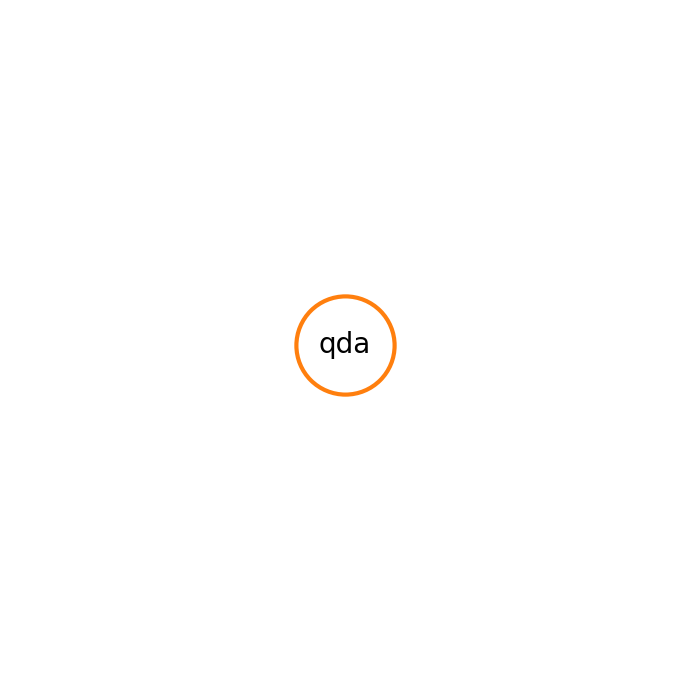

In [8]:
pipeline.show()

In [9]:
prediction = fedot_model.predict_proba(features=x_data)
print(pipeline)
print(f'ROC AUC score on training sample: {roc_auc(y_data, prediction):.3f}')

DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:45,079 - PipelineNode - Obtain prediction in pipeline node by operation: qda
{'depth': 1, 'length': 1, 'nodes': [qda]}
ROC AUC score on training sample: 0.942


### Core-based example

We will transform the data into a specific format (InputData) for the algorithm launch.

In [10]:
import datetime
import numpy as np 

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Repository with operations in the FEDOT
from fedot.core.repository.operation_types_repository import get_operations_for_task

# Pipeline of the FEDOT
from fedot.core.pipelines.pipeline import Pipeline

# Evolutionary algorithm classes 
from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.composer.gp_composer.gp_composer import PipelineComposerRequirements
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum

Let's define the task that we plan to solve - classification

We will also wrap the data in a special structure-Input Data, where we will assign features, specify target, pass the data type (table) and the specified type of the task to be solved.

In [11]:
# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

Now we have identified the data and the task within which we will look for a solution.

Next, we want to find a composite model (pipeline) of such a structure that predicts class labels as accurately as possible. We can determine from which models we can assemble such pipelines.

In [12]:
# The search of the models provided by the framework that can be used as nodes in a pipeline for the selected task
available_model_types = ['scaling', 'bernb', 'dt', 'knn', 'lda', 'logit', 'mlp', 'qda', 'rf', 'xgboost']

Let's set the metric that we will use during the evolution process, select "ROCAUC_penalty"

In [13]:
# The choice of the metric for the pipeline quality assessment during composition
metric_function = ClassificationMetricsEnum.ROCAUC_penalty

#### Composer

Composer is a genetic algorithm that allows you to search for optimal solutions by composing the pipelines of single machine learning models. 

Through PipelineComposerRequirements, we can set some hyperparameters to adjust the behavior of the evolutionary algorithm.

With the help of PipelineComposerRequirements, you can manage:
* types of models that can be inserted into primary nodes
* types of models that can be inserted into secondary nodes

* arity of directed acyclic graph (DAG)
* maximum depth of the found pipeline
* time to find a solution

In [14]:
# The choice and initialisation of the GP search
timeout = datetime.timedelta(minutes=1)
composer_requirements = PipelineComposerRequirements(
    primary=available_model_types,
    secondary=available_model_types, 
    max_arity=3,
    max_depth=3, 
    timeout=timeout,
    cv_folds=2)

Below we will define the genetic scheme of the algorithm. 

There are several schemes:
* steady_state - evolutionary scheme, also known as $(\mu+\lambda)$. New population is generated by using a selection operator which is applied to the union of the offspring and the previous population;
* generational - the offspring completely replaces the parent population;
* parameter_free - steady-state evolutionary scheme, but $\mu$ (population size) changes during evolution like the Fibonacci sequence and $\lambda$ always equals to the previous item of the sequence with respect to $\mu$.

For more information you can check [preprint](https://arxiv.org/abs/2103.01301).

We will also use the GPComposerBuilder structure, which allows you to set parameters in GPComposer.


In [15]:
from fedot.core.composer.gp_composer.specific_operators import parameter_change_mutation
from golem.core.optimisers.genetic.operators.mutation import MutationTypesEnum

In [16]:
# GP optimiser parameters choice
scheme_type = GeneticSchemeTypesEnum.parameter_free
mutation_types = [parameter_change_mutation, MutationTypesEnum.growth, MutationTypesEnum.reduce, MutationTypesEnum.simple]
graph_opt_params = GPAlgorithmParameters(
    genetic_scheme_type=scheme_type,
    mutation_types=mutation_types,
    crossover_prob=0.8,
    mutation_prob=0.8)

# Create builder for composer and set composer params
builder = ComposerBuilder(task=task).\
    with_requirements(composer_requirements).\
    with_optimizer_params(graph_opt_params).\
    with_metrics(metric_function)

# Create GP-based composer
composer = builder.build()

# the optimal pipeline generation by composition - the most time-consuming task
pipeline_evo_composed = composer.compose_pipeline(data=input_data)


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_bernb;;/n_knn;;/n_logit;)/n_knn;;(/n_dt;;/n_logit;)/n_rf;;/n_lda;)/n_scaling.


2023-10-02 19:36:45,215 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_bernb;;/n_knn;;/n_logit;)/n_knn;;(/n_dt;;/n_logit;)/n_rf;;/n_lda;)/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_dt;;/n_logit;;/n_rf;)/n_xgboost;;/n_mlp;)/n_dt.


2023-10-02 19:36:45,438 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_dt;;/n_logit;;/n_rf;)/n_xgboost;;/n_mlp;)/n_dt.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_dt;;/n_lda;;/n_xgboost;)/n_xgboost;;(/n_knn;;/n_qda;;/n_scaling;)/n_mlp;;/n_knn;)/n_scaling.


2023-10-02 19:36:45,641 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_dt;;/n_lda;;/n_xgboost;)/n_xgboost;;(/n_knn;;/n_qda;;/n_scaling;)/n_mlp;;/n_knn;)/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_dt;;/n_logit;;/n_scaling;)/n_lda;;(/n_logit;;/n_scaling;;/n_scaling;)/n_logit;;/n_knn;)/n_knn.


2023-10-02 19:36:45,933 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_dt;;/n_logit;;/n_scaling;)/n_lda;;(/n_logit;;/n_scaling;;/n_scaling;)/n_logit;;/n_knn;)/n_knn.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_mlp;;/n_scaling;)/n_xgboost;;/n_mlp;)/n_knn.


2023-10-02 19:36:45,958 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_mlp;;/n_scaling;)/n_xgboost;;/n_mlp;)/n_knn.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_xgboost;;/n_xgboost;)/n_rf;;/n_lda;;/n_xgboost;)/n_scaling.


2023-10-02 19:36:45,967 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_xgboost;;/n_xgboost;)/n_rf;;/n_lda;;/n_xgboost;)/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_rf;;/n_scaling;)/n_bernb;;/n_knn;;/n_mlp;)/n_scaling.


2023-10-02 19:36:46,046 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x000002A33F9219D0> on graph=((/n_rf;;/n_scaling;)/n_bernb;;/n_knn;;/n_mlp;)/n_scaling.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_mlp;;/n_qda;;/n_scaling;)/n_rf;;/n_mlp;;/n_scaling;)/n_lda.


2023-10-02 19:36:46,303 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_mlp;;/n_qda;;/n_scaling;)/n_rf;;/n_mlp;;/n_scaling;)/n_lda.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_dt;;/n_qda;;/n_qda;)/n_lda;;/n_knn;;/n_rf;)/n_xgboost.


2023-10-02 19:36:46,383 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_dt;;/n_qda;;/n_qda;)/n_lda;;/n_knn;;/n_rf;)/n_xgboost.


DEBUG:root:GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_bernb;;/n_logit;;/n_scaling;)/n_knn;;/n_scaling;)/n_xgboost.


2023-10-02 19:36:46,407 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002A33F923040> on graph=((/n_bernb;;/n_logit;;/n_scaling;)/n_knn;;/n_scaling;)/n_xgboost.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2023-10-02 19:36:46,476 - DataSourceSplitter - K-folds cross validation is applied.


Generations: 1gen [00:00, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-10-02 19:36:46,482 - MultiprocessingDispatcher - Number of used CPU's: 1


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} fit started


2023-10-02 19:36:46,487 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:46,498 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:46,500 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:46,502 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:46,503 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:46,504 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:46,510 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:46,517 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:46,528 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:46,530 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:46,534 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:46,539 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:46,594 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:46,784 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:46,786 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:46,787 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:46,788 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:46,789 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:46,794 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:46,797 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:46,803 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:46,805 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:46,807 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:46,811 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:46,820 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:46,863 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:46,866 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:46,868 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:46,870 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:46,873 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:46,883 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:46,892 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:46,913 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:46,916 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:46,918 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:46,925 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:46,992 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:47,175 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:47,177 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:47,179 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:47,182 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:47,184 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:47,187 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:47,190 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:47,195 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:47,197 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:47,199 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:47,204 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:47,212 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.880684, 0.9)


2023-10-02 19:36:47,243 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.880684, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda fit started


2023-10-02 19:36:47,360 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:47,370 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:47,372 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:47,373 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:47,376 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:47,377 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:47,383 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:47,392 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:47,394 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:47,395 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:47,405 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:47,619 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:47,620 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:47,621 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:47,622 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:47,624 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:47,627 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:47,634 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:47,635 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:47,637 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:47,640 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:47,657 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:47,659 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:47,660 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:47,662 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:47,663 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:47,671 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:47,679 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:47,681 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:47,684 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:47,691 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:47,903 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:47,904 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:47,905 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:47,906 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:47,908 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:47,912 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:47,919 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:47,921 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:47,922 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:47,925 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda with evaluated metrics: (-0.49733333333333335, 0.7)


2023-10-02 19:36:47,935 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda with evaluated metrics: (-0.49733333333333335, 0.7)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit fit started


2023-10-02 19:36:48,024 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:48,034 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,036 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:48,038 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:48,039 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:48,041 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:48,046 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:48,054 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:48,238 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:48,243 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:48,260 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,262 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:48,264 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:48,265 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:48,268 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:48,272 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:48,276 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:48,290 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:48,294 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:48,308 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,311 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:48,314 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:48,317 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:48,319 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:48,324 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:48,332 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:48,524 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:48,529 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:48,544 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,548 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:48,551 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:48,553 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:48,554 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:48,557 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:48,561 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:48,576 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:48,581 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit with evaluated metrics: (-0.9195693333333335, 0.7)


2023-10-02 19:36:48,588 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit with evaluated metrics: (-0.9195693333333335, 0.7)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_logit fit started


2023-10-02 19:36:48,672 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:48,682 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,683 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:48,685 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:48,687 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:48,689 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:48,694 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:48,867 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:48,884 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,886 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:48,888 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:48,890 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:48,891 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:48,895 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:48,912 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:48,927 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:48,929 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:48,931 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:48,933 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:48,936 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:48,943 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:49,114 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:49,131 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:49,133 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:49,135 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:49,136 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:49,138 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:49,141 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:49,157 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_logit with evaluated metrics: (-0.897293, 0.5)


2023-10-02 19:36:49,165 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_logit with evaluated metrics: (-0.897293, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_dt;)/n_mlp fit started


2023-10-02 19:36:49,249 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_dt;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:49,259 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:49,261 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:49,262 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:49,264 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:49,266 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:49,274 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:49,472 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:49,658 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:49,660 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:49,661 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:49,662 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:49,664 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:49,669 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:49,674 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:49,688 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:49,690 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:49,691 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:49,693 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:49,695 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:49,706 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:49,913 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:50,098 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:50,101 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:50,102 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:50,103 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:50,104 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:50,108 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:50,113 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_dt;)/n_mlp with evaluated metrics: (-0.9147113333333334, 0.5)


2023-10-02 19:36:50,121 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_dt;)/n_mlp with evaluated metrics: (-0.9147113333333334, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_scaling;)/n_qda;;/n_lda;)/n_mlp fit started


2023-10-02 19:36:50,208 - PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_scaling;)/n_qda;;/n_lda;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:50,218 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:50,219 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:50,220 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:50,222 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:50,223 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:50,447 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:50,457 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:50,654 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:50,657 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:50,659 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:50,660 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:50,661 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:50,666 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:50,671 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:50,686 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:50,688 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:50,691 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:50,692 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:50,694 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:50,892 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:50,902 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:51,098 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:51,101 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:51,103 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:51,105 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:51,107 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:51,113 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:51,122 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_scaling;)/n_qda;;/n_lda;)/n_mlp with evaluated metrics: (-0.9276506666666666, 0.5)


2023-10-02 19:36:51,134 - PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_scaling;)/n_qda;;/n_lda;)/n_mlp with evaluated metrics: (-0.9276506666666666, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;(/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;)/n_bernb fit started


2023-10-02 19:36:51,221 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;(/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;)/n_bernb fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,231 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,233 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:51,235 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:51,237 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,238 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:51,244 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,255 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,257 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,258 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:51,268 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:51,467 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,538 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,540 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:51,543 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:51,545 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,549 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:51,555 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,563 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,567 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,569 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:51,574 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:51,579 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,610 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,617 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:51,620 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:51,623 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,625 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:51,637 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,653 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,655 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:51,657 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:51,668 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:51,872 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,942 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,944 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:51,948 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:51,951 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,953 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:51,959 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,971 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:36:51,973 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:51,975 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:51,982 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:51,986 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;(/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;)/n_bernb with evaluated metrics: (-0.8168448333333334, 0.8)


2023-10-02 19:36:52,002 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;(/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;)/n_bernb with evaluated metrics: (-0.8168448333333334, 0.8)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


2023-10-02 19:36:52,124 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:52,135 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:52,137 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:52,139 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:52,145 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:52,352 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:52,353 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:52,354 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:52,358 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:52,373 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:52,375 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:52,376 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:52,383 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:52,583 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:52,585 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:52,586 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:52,590 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.92783, 0.3)


2023-10-02 19:36:52,598 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.92783, 0.3)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;)/n_mlp;;/n_mlp;)/n_knn fit started


2023-10-02 19:36:52,682 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;)/n_mlp;;/n_mlp;)/n_knn fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:52,691 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:52,692 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:52,693 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:52,695 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:52,697 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:52,705 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:52,890 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:53,096 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,099 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:53,101 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:53,102 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:53,103 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:53,109 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:53,144 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:53,169 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,172 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:53,175 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:53,177 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:53,178 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:53,185 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:53,387 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:53,631 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,634 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:53,635 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:36:53,636 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:53,637 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:53,641 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:53,645 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;)/n_mlp;;/n_mlp;)/n_knn with evaluated metrics: (-0.8271219999999999, 0.5)


2023-10-02 19:36:53,654 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;)/n_mlp;;/n_mlp;)/n_knn with evaluated metrics: (-0.8271219999999999, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda fit started


2023-10-02 19:36:53,740 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:53,750 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:36:53,752 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:53,754 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,756 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:53,758 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:53,764 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:53,775 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:53,781 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:53,796 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:36:53,799 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:53,801 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,803 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:53,804 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:53,809 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:53,817 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:53,821 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:53,837 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:36:53,838 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:53,840 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,841 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:53,842 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:53,853 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:36:53,864 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:53,871 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:53,887 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:36:53,889 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:53,890 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:36:53,892 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:53,893 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:53,900 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:36:53,907 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:53,911 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda with evaluated metrics: (-0.9099275, 0.6)


2023-10-02 19:36:53,920 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda with evaluated metrics: (-0.9099275, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda fit started


2023-10-02 19:36:54,014 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:54,023 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:54,024 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:54,026 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:54,028 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:54,030 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:54,039 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:54,046 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:54,420 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:54,435 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:54,437 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:54,439 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:54,441 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:54,442 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:54,446 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:54,450 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:54,466 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:54,483 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:54,485 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:54,487 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:54,489 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:54,490 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:54,500 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:54,507 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:54,877 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:54,892 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:54,894 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:54,896 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:54,899 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:54,902 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:54,906 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:54,909 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:54,926 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda with evaluated metrics: (-0.886545, 0.6)


2023-10-02 19:36:54,936 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda with evaluated metrics: (-0.886545, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_mlp;)/n_logit;;/n_logit;)/n_qda fit started


2023-10-02 19:36:55,028 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_mlp;)/n_logit;;/n_logit;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:55,038 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:55,040 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:55,042 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:55,043 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:55,046 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:55,053 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:55,058 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:55,319 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:55,321 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:55,322 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:55,559 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:55,762 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:55,778 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:55,781 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:55,782 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:55,784 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:55,785 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:55,789 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:55,791 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:55,817 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:55,820 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:55,822 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:55,827 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:55,835 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:55,861 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:55,865 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:55,867 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:55,869 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:55,871 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:55,884 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:55,892 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:56,156 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:56,158 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:56,159 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:56,354 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:56,557 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:56,572 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,574 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:56,575 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:56,576 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:56,578 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:56,584 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:56,587 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:56,610 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:56,614 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:56,617 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:56,622 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:56,628 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_mlp;)/n_logit;;/n_logit;)/n_qda with evaluated metrics: (-0.8419179999999999, 0.9)


2023-10-02 19:36:56,642 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_mlp;)/n_logit;;/n_logit;)/n_qda with evaluated metrics: (-0.8419179999999999, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_scaling;)/n_qda fit started


2023-10-02 19:36:56,750 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:56,759 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,761 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:56,764 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,766 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:56,768 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:56,776 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:56,788 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:56,803 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,806 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:56,807 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,809 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:56,810 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:56,815 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:56,822 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:56,837 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,840 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:56,841 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,842 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:56,843 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:56,855 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:56,868 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:56,883 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,885 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:56,886 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:36:56,887 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:56,889 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:56,893 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:56,902 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_scaling;)/n_qda with evaluated metrics: (-0.9266553333333334, 0.5)


2023-10-02 19:36:56,936 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_scaling;)/n_qda with evaluated metrics: (-0.9266553333333334, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_mlp;)/n_dt fit started


2023-10-02 19:36:57,044 - PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_mlp;)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:57,055 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:57,057 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:57,058 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:57,065 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:57,269 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:57,271 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:57,272 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:57,276 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:57,289 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:57,291 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:57,293 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:57,302 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:57,506 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:57,508 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:57,509 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:57,512 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_mlp;)/n_dt with evaluated metrics: (-0.829061, 0.3)


2023-10-02 19:36:57,520 - PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_mlp;)/n_dt with evaluated metrics: (-0.829061, 0.3)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


2023-10-02 19:36:57,606 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:57,615 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,618 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:57,620 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,621 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:57,623 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:57,630 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:57,689 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:57,751 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,753 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:57,754 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,755 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:57,756 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:57,761 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:57,770 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:57,796 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,802 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:36:57,806 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,808 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:36:57,811 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:57,824 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:57,884 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:57,983 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,985 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:36:57,987 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:36:57,989 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:36:57,990 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:57,999 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:58,006 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.9097346666666667, 0.5)


2023-10-02 19:36:58,018 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.9097346666666667, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_rf_{'n_jobs': 1};)/n_dt fit started


2023-10-02 19:36:58,144 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_rf_{'n_jobs': 1};)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:58,155 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:58,157 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:58,158 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:58,160 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:58,162 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:58,169 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:58,361 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:58,556 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:58,558 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:58,559 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:58,566 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:58,829 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:59,024 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:59,026 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:59,027 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:59,029 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:59,032 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:59,036 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:36:59,039 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:59,043 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:59,046 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:36:59,048 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:36:59,054 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:36:59,076 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:36:59,120 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:59,123 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:36:59,125 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:59,127 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:36:59,129 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:59,140 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:36:59,341 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:59,535 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:36:59,536 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:36:59,538 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:36:59,543 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:36:59,801 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:36:59,990 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:36:59,992 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:36:59,993 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:36:59,995 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:36:59,996 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:00,001 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:00,006 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:00,011 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:00,014 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:00,017 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:00,022 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:00,085 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.850367, 0.9)


2023-10-02 19:37:00,124 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.850367, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_logit;;/n_bernb;;/n_scaling;)/n_qda fit started


2023-10-02 19:37:00,217 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_logit;;/n_bernb;;/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:00,225 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:00,227 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:00,228 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:00,231 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:00,233 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:00,239 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:00,253 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:00,259 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:00,276 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:00,278 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:00,280 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:00,282 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:00,285 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:00,288 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:00,293 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:00,297 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:00,312 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:00,316 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:00,319 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:00,320 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:00,323 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:00,328 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:00,344 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:00,353 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:00,369 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:00,371 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:00,373 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:00,374 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:00,375 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:00,379 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:00,386 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:00,389 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_logit;;/n_bernb;;/n_scaling;)/n_qda with evaluated metrics: (-0.8268449999999999, 0.6)


2023-10-02 19:37:00,398 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_logit;;/n_bernb;;/n_scaling;)/n_qda with evaluated metrics: (-0.8268449999999999, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} fit started


2023-10-02 19:37:00,491 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:00,501 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:00,503 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:00,505 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:00,506 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:00,508 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:00,516 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:00,883 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:01,109 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,111 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:01,112 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,115 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:01,118 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:01,121 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:01,137 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:01,161 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,163 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:01,165 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,167 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:01,169 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:01,175 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:01,545 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:01,722 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,724 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:01,725 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,726 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:01,728 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:01,733 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:01,749 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.8858466666666667, 0.5)


2023-10-02 19:37:01,766 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.8858466666666667, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp fit started


2023-10-02 19:37:01,862 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:01,873 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:01,875 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:01,876 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:01,877 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:01,878 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:01,888 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:01,893 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:01,904 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:01,907 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:01,908 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:01,915 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:01,922 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:02,183 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:02,568 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:02,570 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:02,571 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:02,572 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:02,573 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:02,577 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:02,582 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:02,588 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:02,591 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:02,592 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:02,604 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:02,631 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:02,659 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:02,693 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:02,695 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:02,698 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:02,700 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:02,702 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:02,712 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:02,722 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:02,735 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:02,737 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:02,739 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:02,751 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:02,758 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:03,073 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:03,445 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:03,448 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:03,450 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:03,451 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:03,452 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:03,454 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:03,459 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:03,464 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:03,466 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:03,468 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:03,472 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:03,476 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:03,500 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp with evaluated metrics: (-0.9166575000000001, 1.0)


2023-10-02 19:37:03,511 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp with evaluated metrics: (-0.9166575000000001, 1.0)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_knn;)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_rf_{'n_jobs': 1};;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_logit;)/n_dt fit started


2023-10-02 19:37:03,629 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_knn;)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_rf_{'n_jobs': 1};;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_logit;)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:03,638 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:03,639 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:03,641 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:03,642 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:03,643 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:03,650 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:03,826 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:03,828 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:03,831 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:04,027 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:04,209 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:04,480 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:04,495 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:04,497 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:04,500 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:04,502 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:04,503 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:04,508 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:04,523 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:04,526 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:04,528 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:04,532 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:04,548 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:04,571 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:04,594 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:04,598 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:04,600 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:04,602 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:04,604 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:04,615 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:04,810 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:04,812 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:04,815 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:05,011 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:05,192 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:05,460 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:05,476 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:05,478 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:05,480 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:05,482 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:05,485 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:05,489 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:05,505 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:05,507 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:05,509 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:05,513 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:05,527 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:05,550 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_knn;)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_rf_{'n_jobs': 1};;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_logit;)/n_dt with evaluated metrics: (-0.871241, 0.9)


2023-10-02 19:37:05,561 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_knn;)/n_rf_{'n_jobs': 1};;(/n_mlp;;/n_rf_{'n_jobs': 1};;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_logit;)/n_dt with evaluated metrics: (-0.871241, 0.9)


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-10-02 19:37:05,717 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 20


2023-10-02 19:37:05,766 - EvoGraphOptimizer - Generation num: 1 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


2023-10-02 19:37:05,768 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-10-02 19:37:05,838 - MultiprocessingDispatcher - Number of used CPU's: 1


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt fit started


2023-10-02 19:37:05,843 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:05,854 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:05,856 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:05,858 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:05,859 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:05,860 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:05,868 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:06,070 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:06,269 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:06,271 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:06,273 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:06,278 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:06,543 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:06,546 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:06,549 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:06,551 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:06,552 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:06,556 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:06,559 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:06,564 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:06,567 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:06,569 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:06,574 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:06,615 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:06,619 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:06,622 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:06,628 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:06,633 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:06,642 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:06,847 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:07,045 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:07,048 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:07,050 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:07,055 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:07,385 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:07,386 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:07,387 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:07,388 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:07,389 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:07,392 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:07,398 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:07,403 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:07,404 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:07,406 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:07,411 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.844189, 0.8)


2023-10-02 19:37:07,440 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.844189, 0.8)


CRITICAL:root:MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


2023-10-02 19:37:07,553 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 21


2023-10-02 19:37:07,606 - EvoGraphOptimizer - Generation num: 2 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


2023-10-02 19:37:07,607 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-10-02 19:37:07,608 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2023-10-02 19:37:07,609 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 3


2023-10-02 19:37:07,610 - EvoGraphOptimizer - Next population size: 34; max graph depth: 3


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,163 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,219 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,261 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,314 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,352 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,393 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,428 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,479 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,504 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,564 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,612 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,659 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,715 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,749 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,774 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,810 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,869 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,914 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:08,949 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:09,008 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-10-02 19:37:09,010 - MultiprocessingDispatcher - Number of used CPU's: 1


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp fit started


2023-10-02 19:37:09,016 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:09,025 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:09,026 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:09,027 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:09,028 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:09,031 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:09,039 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:09,044 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:09,053 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:09,055 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:09,056 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:09,062 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:09,072 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:09,372 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:09,752 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:09,753 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:09,755 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:09,756 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:09,757 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:09,762 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:09,767 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:09,771 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:09,774 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:09,775 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:09,779 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:09,785 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:09,807 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:09,833 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:09,836 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:09,838 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:09,839 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:09,841 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:09,853 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:09,861 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:09,874 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:09,876 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:09,881 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:09,890 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:09,895 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:10,161 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:10,543 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:10,545 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:10,547 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:10,549 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:10,551 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:10,554 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:10,558 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:10,562 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:10,565 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:10,567 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:10,571 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:10,575 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:10,599 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp with evaluated metrics: (-0.9166575000000001, 1.0)


2023-10-02 19:37:10,610 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp with evaluated metrics: (-0.9166575000000001, 1.0)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} fit started


2023-10-02 19:37:10,742 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:10,753 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:10,755 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:10,756 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:10,758 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:10,759 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:10,766 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:11,125 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:11,306 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:11,308 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:11,309 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:11,311 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:11,312 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:11,317 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:11,333 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:11,359 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:11,361 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:11,362 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:11,365 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:11,366 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:11,372 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:11,751 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:11,934 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:11,936 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:11,937 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:11,939 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:11,940 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:11,944 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:11,958 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.8858466666666667, 0.5)


2023-10-02 19:37:11,976 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.8858466666666667, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_bernb;;/n_scaling;)/n_qda fit started


2023-10-02 19:37:12,111 - PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_bernb;;/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:12,121 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:12,123 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:12,124 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:12,125 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:12,128 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:12,136 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:12,405 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:12,410 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:12,423 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:12,425 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:12,426 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:12,428 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:12,431 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:12,436 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:12,459 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:12,465 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:12,490 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:12,493 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:12,495 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:12,502 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:12,505 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:12,514 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:12,771 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:12,777 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:12,790 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:12,792 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:12,793 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:12,795 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:12,799 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:12,806 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:12,828 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:12,834 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_bernb;;/n_scaling;)/n_qda with evaluated metrics: (-0.84376, 0.6)


2023-10-02 19:37:12,846 - PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_bernb;;/n_scaling;)/n_qda with evaluated metrics: (-0.84376, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_dt;;/n_qda;)/n_logit;;/n_rf_{'n_jobs': 1};)/n_dt fit started


2023-10-02 19:37:12,962 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_dt;;/n_qda;)/n_logit;;/n_rf_{'n_jobs': 1};)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:12,972 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:12,974 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:12,975 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:12,977 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:12,978 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:12,985 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:13,222 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:13,454 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:13,456 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:13,458 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:13,462 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:13,474 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:13,672 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:13,674 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:13,675 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:13,676 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:13,677 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:13,682 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:13,686 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:13,691 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:13,692 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:13,694 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:13,698 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:13,706 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:13,743 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:13,745 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:13,747 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:13,749 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:13,752 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:13,761 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:13,960 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:14,160 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:14,161 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:14,163 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:14,169 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:14,181 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:14,387 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:14,389 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:14,390 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:14,392 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:14,394 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:14,398 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:14,401 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:14,406 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:14,408 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:14,410 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:14,413 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:14,422 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_dt;;/n_qda;)/n_logit;;/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.850367, 0.9)


2023-10-02 19:37:14,438 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_dt;;/n_qda;)/n_logit;;/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.850367, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_mlp;)/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


2023-10-02 19:37:14,528 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_mlp;)/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:14,538 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:14,539 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:14,540 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:14,541 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:14,542 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:14,551 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:14,802 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:14,861 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:14,864 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:14,865 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:14,867 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:14,868 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:14,871 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:14,876 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:14,902 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:14,904 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:14,907 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:14,909 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:14,912 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:14,921 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:15,134 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:15,195 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:15,198 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:15,199 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:15,200 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:15,201 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:15,206 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:15,210 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_mlp;)/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.9007766666666668, 0.5)


2023-10-02 19:37:15,222 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_mlp;)/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.9007766666666668, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


2023-10-02 19:37:15,348 - PipelineObjectiveEvaluate - Pipeline (/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:15,357 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:15,359 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:15,360 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:15,368 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:15,429 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:15,432 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:15,434 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:15,439 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:15,508 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:15,511 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:15,513 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:15,524 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:15,603 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:15,606 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:15,607 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:15,612 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.9213451666666668, 0.3)


2023-10-02 19:37:15,623 - PipelineObjectiveEvaluate - Pipeline (/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.9213451666666668, 0.3)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_mlp;)/n_logit;;/n_scaling;)/n_qda fit started


2023-10-02 19:37:15,742 - PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_mlp;)/n_logit;;/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:15,754 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:15,757 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:15,758 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:15,759 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:15,760 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:15,954 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:16,150 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:16,163 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:16,165 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:16,167 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:16,169 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:16,170 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:16,174 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:16,178 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:16,233 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:16,235 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:16,237 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:16,239 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:16,240 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:16,454 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:16,652 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:16,665 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:16,667 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:16,669 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:16,670 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:16,671 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:16,676 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:16,681 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_mlp;)/n_logit;;/n_scaling;)/n_qda with evaluated metrics: (-0.9196880000000001, 0.5)


2023-10-02 19:37:16,689 - PipelineObjectiveEvaluate - Pipeline ((/n_mlp;;/n_mlp;)/n_logit;;/n_scaling;)/n_qda with evaluated metrics: (-0.9196880000000001, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_logit;;/n_logit;)/n_qda;;/n_logit;)/n_qda fit started


2023-10-02 19:37:16,787 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_logit;;/n_logit;)/n_qda;;/n_logit;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:16,796 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:16,798 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:16,801 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:16,802 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:16,803 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:16,811 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:16,818 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:17,074 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,076 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,078 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,085 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,097 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:17,122 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,136 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:17,141 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:17,145 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:17,150 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:17,154 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:17,158 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:17,188 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,191 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:17,193 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:17,198 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:17,207 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:17,238 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,241 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:17,243 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:17,245 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:17,248 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:17,258 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:17,267 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:17,547 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,549 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,550 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,557 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,568 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:17,585 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,587 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:17,588 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:17,589 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:17,591 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:17,597 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:17,601 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:17,625 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,628 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:17,631 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:17,635 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:17,644 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_logit;;/n_logit;)/n_qda;;/n_logit;)/n_qda with evaluated metrics: (-0.8399300000000001, 0.9)


2023-10-02 19:37:17,657 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_logit;;/n_logit;)/n_qda;;/n_logit;)/n_qda with evaluated metrics: (-0.8399300000000001, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda fit started


2023-10-02 19:37:17,810 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:17,821 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:17,822 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:17,824 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:17,825 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,826 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:17,835 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:17,842 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:18,221 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:18,237 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:18,239 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:18,240 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:18,243 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:18,244 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:18,249 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:18,252 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:18,268 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:18,284 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:18,286 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:18,288 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:18,289 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:18,291 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:18,302 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:18,309 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:18,681 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:18,695 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:18,697 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:18,700 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:18,702 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:18,703 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:18,709 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:18,712 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:18,734 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda with evaluated metrics: (-0.886545, 0.6)


2023-10-02 19:37:18,741 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_bernb;)/n_qda with evaluated metrics: (-0.886545, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda fit started


2023-10-02 19:37:18,859 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:18,874 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:18,875 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:18,877 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:18,878 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:18,879 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:18,887 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:18,898 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:18,904 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:18,921 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:18,923 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:18,924 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:18,925 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:18,927 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:18,933 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:18,940 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:18,944 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:18,962 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:18,967 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:18,969 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:18,970 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:18,972 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:18,979 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:18,992 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:19,000 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:19,013 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:19,016 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:19,018 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:19,019 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:19,020 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:19,025 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:19,033 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:19,037 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda with evaluated metrics: (-0.9099275, 0.6)


2023-10-02 19:37:19,044 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_knn;;/n_scaling;)/n_lda with evaluated metrics: (-0.9099275, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_qda;;/n_mlp;)/n_knn fit started


2023-10-02 19:37:19,137 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_qda;;/n_mlp;)/n_knn fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:19,146 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:19,149 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:19,150 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:19,151 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:19,155 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:19,160 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:19,367 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:19,568 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:19,570 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:19,571 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:19,572 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:19,573 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:19,577 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:19,584 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:19,600 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:19,602 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:19,604 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:19,606 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:19,608 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:19,616 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:19,817 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:20,021 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:20,022 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:20,024 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:20,025 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:20,027 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:20,031 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:20,037 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_qda;;/n_mlp;)/n_knn with evaluated metrics: (-0.9157066666666667, 0.5)


2023-10-02 19:37:20,044 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_qda;;/n_mlp;)/n_knn with evaluated metrics: (-0.9157066666666667, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_dt;)/n_mlp fit started


2023-10-02 19:37:20,141 - PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_dt;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:20,154 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:20,156 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:20,157 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:20,162 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:20,404 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:20,406 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:20,407 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:20,410 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:20,424 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:20,426 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:20,428 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:20,435 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:20,669 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:20,671 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:20,672 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:20,675 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_dt;)/n_mlp with evaluated metrics: (-0.8305575000000001, 0.3)


2023-10-02 19:37:20,681 - PipelineObjectiveEvaluate - Pipeline (/n_dt;;/n_dt;)/n_mlp with evaluated metrics: (-0.8305575000000001, 0.3)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;(/n_mlp;;/n_scaling;)/n_qda;)/n_bernb fit started


2023-10-02 19:37:20,774 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;(/n_mlp;;/n_scaling;)/n_qda;)/n_bernb fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:20,784 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:20,785 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:20,786 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:20,788 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:20,790 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:20,797 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:21,043 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:21,092 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:21,094 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:21,098 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:21,317 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:21,334 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:21,335 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:21,336 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:21,338 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:21,339 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:21,344 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:21,348 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:21,355 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:21,359 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:21,361 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:21,366 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:21,393 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:21,396 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:21,398 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:21,401 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:21,404 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:21,414 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:21,629 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:21,679 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:21,683 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:21,685 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:21,914 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:21,931 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:21,933 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:21,935 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:21,938 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:21,939 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:21,942 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:21,946 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:21,953 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:21,956 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:21,959 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:21,964 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;(/n_mlp;;/n_scaling;)/n_qda;)/n_bernb with evaluated metrics: (-0.49716666666666665, 0.8)


2023-10-02 19:37:21,978 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;(/n_mlp;;/n_scaling;)/n_qda;)/n_bernb with evaluated metrics: (-0.49716666666666665, 0.8)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;/n_lda;)/n_mlp fit started


2023-10-02 19:37:22,100 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;/n_lda;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:22,110 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:22,112 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:22,115 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:22,117 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:22,118 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:22,123 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:22,134 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:22,323 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:22,325 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:22,326 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:22,327 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:22,328 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:22,334 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:22,339 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:22,355 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:22,357 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:22,358 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:22,359 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:22,360 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:22,369 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:22,381 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:22,589 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:22,590 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:22,591 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:22,594 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:22,595 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:22,600 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:22,605 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;/n_lda;)/n_mlp with evaluated metrics: (-0.9162043333333334, 0.5)


2023-10-02 19:37:22,613 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_lda;)/n_dt;;/n_lda;)/n_mlp with evaluated metrics: (-0.9162043333333334, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_dt;)/n_mlp fit started


2023-10-02 19:37:22,705 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_dt;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:22,721 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:22,754 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:22,757 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:22,758 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:22,759 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:22,770 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:22,950 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:23,136 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:23,137 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:23,138 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:23,139 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:23,140 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:23,144 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:23,160 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:23,174 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:23,177 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:23,179 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:23,181 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:23,183 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:23,189 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:23,361 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:23,560 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:23,562 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:23,563 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:23,565 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:23,567 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:23,570 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:23,586 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_dt;)/n_mlp with evaluated metrics: (-0.886842, 0.5)


2023-10-02 19:37:23,592 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_lda;)/n_rf_{'n_jobs': 1};;/n_dt;)/n_mlp with evaluated metrics: (-0.886842, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_bernb;)/n_logit fit started


2023-10-02 19:37:23,685 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_bernb;)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:23,700 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:23,726 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:23,729 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:23,731 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:23,732 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:23,744 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:23,951 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:23,967 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:23,970 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:23,971 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:23,973 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:23,975 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:23,980 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:23,986 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:24,001 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:24,002 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:24,003 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:24,004 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:24,005 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:24,017 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:24,220 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:24,237 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:24,238 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:24,239 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:24,240 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:24,242 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:24,245 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:24,253 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_bernb;)/n_logit with evaluated metrics: (-0.924167, 0.5)


2023-10-02 19:37:24,259 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_bernb;)/n_logit with evaluated metrics: (-0.924167, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit fit started


2023-10-02 19:37:24,359 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:24,373 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:24,376 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:24,378 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:24,381 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:24,385 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:24,390 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:24,399 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:24,633 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:24,638 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:24,653 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:24,655 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:24,656 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:24,658 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:24,661 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:24,666 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:24,670 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:24,685 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:24,688 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:24,704 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:24,706 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:24,707 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:24,709 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:24,710 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:24,718 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:24,724 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:24,927 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:24,933 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:24,948 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:24,951 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:24,952 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:24,954 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:24,955 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:24,960 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:24,967 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:24,986 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:24,990 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit with evaluated metrics: (-0.9195693333333335, 0.7)


2023-10-02 19:37:24,996 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit with evaluated metrics: (-0.9195693333333335, 0.7)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda fit started


2023-10-02 19:37:25,099 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:25,108 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:25,110 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:25,112 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:25,114 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:25,116 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:25,121 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:25,132 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:25,135 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:25,137 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:25,175 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:25,395 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:25,398 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:25,399 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:25,402 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:25,403 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:25,406 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:25,411 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:25,413 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:25,415 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:25,419 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:25,440 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:25,442 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:25,444 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:25,446 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:25,449 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:25,457 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:25,472 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:25,475 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:25,477 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:25,486 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:25,697 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:25,699 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:25,701 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:25,702 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:25,704 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:25,707 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:25,712 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:25,715 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:25,716 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:25,720 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda with evaluated metrics: (-0.49733333333333335, 0.7)


2023-10-02 19:37:25,729 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_qda;)/n_dt;;(/n_logit;;/n_mlp;)/n_scaling;)/n_qda with evaluated metrics: (-0.49733333333333335, 0.7)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} fit started


2023-10-02 19:37:25,826 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:25,837 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:25,839 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:25,840 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:25,842 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:25,843 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:25,852 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:26,061 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:26,259 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:26,260 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:26,262 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:26,268 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:26,325 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:26,568 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:26,570 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:26,572 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:26,574 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:26,576 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:26,580 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:26,585 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:26,590 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:26,592 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:26,594 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:26,602 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:26,612 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:26,693 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:26,698 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:26,710 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:26,712 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:26,716 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:26,722 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:26,940 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:27,138 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:27,140 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:27,141 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:27,148 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:27,242 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:27,458 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:27,460 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:27,461 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:27,464 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:27,466 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:27,469 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:27,473 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:27,477 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:27,479 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:27,482 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:27,486 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:27,494 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.913486, 0.9)


2023-10-02 19:37:27,524 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_logit;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.913486, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt fit started


2023-10-02 19:37:27,657 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:27,672 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:27,674 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:27,675 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:27,677 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:27,678 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:27,685 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:27,690 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:27,703 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:27,705 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:27,706 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:27,713 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:28,039 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:28,041 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:28,042 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:28,044 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:28,047 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:28,050 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:28,053 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:28,058 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:28,059 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:28,061 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:28,066 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:28,106 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:28,109 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:28,111 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:28,114 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:28,116 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:28,125 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:28,134 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:28,150 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:28,152 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:28,154 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:28,159 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:28,436 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:28,438 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:28,439 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:28,440 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:28,441 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:28,445 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:28,449 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:28,454 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:28,456 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:28,457 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:28,462 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.826291, 0.8)


2023-10-02 19:37:28,491 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.826291, 0.8)


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-10-02 19:37:28,628 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,023 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,088 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,128 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,173 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,219 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,254 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,298 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,349 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,457 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,482 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,519 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,555 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,588 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


DEBUG:root:Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


2023-10-02 19:37:29,651 - Mutation - Number of mutation attempts exceeded. Please check optimization parameters for correctness.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-10-02 19:37:29,653 - MultiprocessingDispatcher - Number of used CPU's: 1


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_dt;;/n_mlp;)/n_dt;;/n_logit;)/n_qda fit started


2023-10-02 19:37:29,658 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_dt;;/n_mlp;)/n_dt;;/n_logit;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:29,668 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:29,670 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:29,671 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:29,673 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:29,674 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:29,683 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:29,688 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:29,976 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:29,978 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:29,980 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:29,986 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:30,180 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:30,196 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:30,198 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:30,200 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:30,201 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:30,203 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:30,206 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:30,210 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:30,235 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:30,238 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:30,240 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:30,245 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:30,252 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:30,276 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:30,279 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:30,281 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:30,283 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:30,286 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:30,297 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:30,305 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:30,617 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:30,620 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:30,621 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:30,626 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:30,820 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:30,836 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:30,838 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:30,840 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:30,841 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:30,842 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:30,847 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:30,851 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:30,873 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:30,875 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:30,877 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:30,883 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:30,890 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_dt;;/n_mlp;)/n_dt;;/n_logit;)/n_qda with evaluated metrics: (-0.497, 0.9)


2023-10-02 19:37:30,903 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_dt;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;(/n_dt;;/n_mlp;)/n_dt;;/n_logit;)/n_qda with evaluated metrics: (-0.497, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_mlp;;/n_mlp;)/n_logit fit started


2023-10-02 19:37:31,024 - PipelineObjectiveEvaluate - Pipeline (/n_mlp;;/n_mlp;)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:31,034 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:31,037 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:31,038 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:31,231 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:31,438 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:31,440 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:31,441 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:31,444 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:31,458 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:31,460 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:31,461 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:31,711 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:31,917 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:31,918 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:31,919 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:31,923 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_mlp;;/n_mlp;)/n_logit with evaluated metrics: (-0.92783, 0.3)


2023-10-02 19:37:31,930 - PipelineObjectiveEvaluate - Pipeline (/n_mlp;;/n_mlp;)/n_logit with evaluated metrics: (-0.92783, 0.3)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_dt;)/n_mlp fit started


2023-10-02 19:37:32,027 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_dt;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:32,038 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:32,040 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:32,041 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,043 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:32,044 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:32,052 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:32,064 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:32,309 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:32,311 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:32,313 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,316 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:32,317 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:32,320 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:32,325 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:32,345 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:32,348 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:32,351 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,352 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:32,354 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:32,369 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:32,386 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:32,574 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:32,576 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:32,578 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,579 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:32,581 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:32,584 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:32,590 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_dt;)/n_mlp with evaluated metrics: (-0.921181, 0.5)


2023-10-02 19:37:32,598 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;)/n_qda;;/n_dt;)/n_mlp with evaluated metrics: (-0.921181, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_scaling;)/n_qda fit started


2023-10-02 19:37:32,701 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_scaling;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:32,710 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,713 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:32,715 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:32,716 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:32,718 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:32,726 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:32,936 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:32,949 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,951 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:32,953 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:32,955 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:32,956 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:32,959 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:32,966 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:32,983 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:32,985 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:32,987 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:32,989 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:32,990 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:32,998 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:33,235 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:33,247 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:33,250 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:33,251 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:33,253 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:33,254 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:33,258 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:33,263 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_scaling;)/n_qda with evaluated metrics: (-0.9117253333333333, 0.5)


2023-10-02 19:37:33,272 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_mlp;)/n_knn;;/n_scaling;)/n_qda with evaluated metrics: (-0.9117253333333333, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


2023-10-02 19:37:33,378 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:33,389 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:33,391 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:33,392 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:33,401 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:33,614 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:33,616 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:33,617 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:33,621 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:33,635 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:33,637 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:33,638 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:33,645 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:33,860 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:33,861 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:33,864 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:33,868 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.92783, 0.3)


2023-10-02 19:37:33,875 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.92783, 0.3)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp fit started


2023-10-02 19:37:33,976 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:33,987 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:33,989 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:33,990 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:33,992 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:33,993 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:34,000 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:34,006 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:34,014 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:34,016 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:34,017 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:34,022 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:34,028 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:34,327 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:34,708 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:34,710 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:34,711 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:34,713 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:34,715 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:34,719 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:34,722 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:34,726 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:34,728 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:34,729 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:34,736 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:34,740 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:34,762 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:34,786 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:34,788 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:34,790 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:34,792 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:34,794 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:34,804 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:34,814 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:34,828 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:34,835 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:34,837 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:34,844 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:34,852 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:35,207 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:35,578 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:35,581 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:35,583 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:35,585 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:35,586 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:35,589 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:35,593 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:35,598 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:35,601 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:35,603 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:35,609 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:35,615 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:35,638 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp with evaluated metrics: (-0.9166575000000001, 1.0)


2023-10-02 19:37:35,650 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_knn;;/n_scaling;)/n_dt;;(/n_knn;;/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};;/n_mlp;)/n_mlp with evaluated metrics: (-0.9166575000000001, 1.0)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt fit started


2023-10-02 19:37:35,773 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:35,784 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:35,786 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:35,788 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:35,789 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:35,791 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:35,800 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:35,807 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:36,224 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:36,226 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:36,227 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:36,234 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:36,496 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:36,499 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:36,501 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:36,503 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:36,504 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:36,507 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:36,510 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:36,525 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:36,527 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:36,529 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:36,535 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:36,575 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:36,577 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:36,580 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:36,582 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:36,585 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:36,597 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:36,605 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:36,983 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:36,985 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:36,986 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:36,992 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:37,258 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:37,260 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:37,261 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:37,262 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:37,264 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:37,268 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:37,271 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:37,286 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:37,289 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:37,291 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:37,297 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.8600983333333333, 0.8)


2023-10-02 19:37:37,326 - PipelineObjectiveEvaluate - Pipeline ((/n_logit;;/n_logit;;/n_mlp;)/n_rf_{'n_jobs': 1};;(/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_rf_{'n_jobs': 1};)/n_dt with evaluated metrics: (-0.8600983333333333, 0.8)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;/n_bernb;)/n_qda fit started


2023-10-02 19:37:37,445 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;/n_bernb;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:37,456 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:37,458 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:37,459 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:37,461 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:37,462 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:37,470 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:37,719 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:37,914 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:37,927 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:37,930 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:37,932 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:37,934 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:37,935 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:37,938 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:37,942 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:37,948 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:37,970 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:37,972 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:37,974 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:37,975 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:37,977 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:37,987 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:38,190 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:38,438 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:38,453 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:38,455 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:38,456 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: scaling


2023-10-02 19:37:38,458 - PipelineNode - Fit all parent nodes in secondary node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:38,459 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:38,464 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:38,467 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:38,472 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;/n_bernb;)/n_qda with evaluated metrics: (-0.9059475, 0.6)


2023-10-02 19:37:38,481 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;;/n_mlp;)/n_scaling;;/n_bernb;)/n_qda with evaluated metrics: (-0.9059475, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} fit started


2023-10-02 19:37:38,579 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:38,590 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:38,592 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:38,594 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:38,597 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:38,599 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:38,606 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:39,026 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:39,205 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:39,207 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:39,208 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:39,209 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:39,210 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:39,215 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:39,229 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:39,256 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:39,258 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:39,259 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:39,260 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:39,261 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:39,270 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:39,644 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:39,829 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:39,831 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:39,833 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:39,834 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:39,835 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:39,840 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:39,854 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.8858466666666667, 0.5)


2023-10-02 19:37:39,874 - PipelineObjectiveEvaluate - Pipeline ((/n_bernb;;/n_mlp;)/n_rf_{'n_jobs': 1};;/n_knn;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.8858466666666667, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit fit started


2023-10-02 19:37:40,015 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:40,024 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:40,026 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:40,028 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:40,030 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:40,032 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:40,038 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:40,044 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:40,239 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:40,243 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:40,259 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:40,260 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:40,263 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:40,265 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:40,267 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:40,271 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:40,275 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:40,290 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:40,294 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:40,307 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:40,309 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:40,310 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:40,311 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:40,314 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:40,322 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:40,327 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:40,599 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:40,604 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:40,624 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:40,626 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:40,629 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: dt


2023-10-02 19:37:40,631 - PipelineNode - Fit all parent nodes in secondary node with operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:40,633 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:40,638 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:40,642 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:40,663 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:40,667 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit with evaluated metrics: (-0.9195693333333335, 0.7)


2023-10-02 19:37:40,673 - PipelineObjectiveEvaluate - Pipeline ((/n_knn;;/n_lda;;/n_rf_{'n_jobs': 1};)/n_dt;;/n_knn;;/n_scaling;)/n_logit with evaluated metrics: (-0.9195693333333335, 0.7)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


2023-10-02 19:37:40,775 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:40,788 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:40,824 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:40,828 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:40,833 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:40,836 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:40,853 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:40,876 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:40,954 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:40,956 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:40,957 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:40,959 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:40,960 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:40,966 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:40,975 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:41,035 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,043 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:41,050 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:41,053 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:41,056 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:41,068 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:41,084 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:41,155 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,157 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:41,158 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: knn


2023-10-02 19:37:41,160 - PipelineNode - Fit all parent nodes in secondary node with operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:41,161 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:41,167 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:41,173 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.915209, 0.5)


2023-10-02 19:37:41,185 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_qda;)/n_knn;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit with evaluated metrics: (-0.915209, 0.5)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_knn;;/n_scaling;)/n_lda fit started


2023-10-02 19:37:41,320 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_knn;;/n_scaling;)/n_lda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:41,330 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:41,333 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:41,337 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,339 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:41,340 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:41,348 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:41,412 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:41,419 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:41,433 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:41,435 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:41,437 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,438 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:41,439 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:41,444 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:41,453 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:41,459 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:41,487 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:41,489 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:41,491 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,493 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:41,496 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:41,509 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:41,569 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:41,575 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:41,597 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: lda


2023-10-02 19:37:41,599 - PipelineNode - Fit all parent nodes in secondary node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:41,601 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,602 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:41,604 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:41,611 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:41,622 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:41,628 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_knn;;/n_scaling;)/n_lda with evaluated metrics: (-0.8760975, 0.6)


2023-10-02 19:37:41,641 - PipelineObjectiveEvaluate - Pipeline ((/n_lda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_logit;;/n_knn;;/n_scaling;)/n_lda with evaluated metrics: (-0.8760975, 0.6)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_mlp;;/n_scaling;)/n_qda;;/n_logit;)/n_rf_{'n_jobs': 1} fit started


2023-10-02 19:37:41,777 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_mlp;;/n_scaling;)/n_qda;;/n_logit;)/n_rf_{'n_jobs': 1} fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:41,789 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:41,791 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:41,792 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:41,793 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:41,795 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:41,802 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:41,808 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:41,820 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:41,822 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:41,823 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:42,078 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:42,087 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:42,309 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:42,311 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:42,313 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:42,316 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:42,318 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:42,321 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:42,325 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:42,331 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:42,333 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:42,335 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:42,340 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:42,345 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: rf


2023-10-02 19:37:42,382 - PipelineNode - Trying to fit pipeline node with operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:42,384 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:42,385 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:42,387 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:42,388 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: dt


2023-10-02 19:37:42,395 - PipelineNode - Trying to fit pipeline node with operation: dt


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: knn


2023-10-02 19:37:42,404 - PipelineNode - Trying to fit pipeline node with operation: knn


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:42,420 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:42,423 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:42,424 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: scaling


2023-10-02 19:37:42,696 - PipelineNode - Trying to fit pipeline node with operation: scaling


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: logit


2023-10-02 19:37:42,705 - PipelineNode - Trying to fit pipeline node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: rf


2023-10-02 19:37:42,924 - PipelineNode - Obtain prediction in pipeline node by operation: rf


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: rf


2023-10-02 19:37:42,925 - PipelineNode - Fit all parent nodes in secondary node with operation: rf


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:42,926 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: logit


2023-10-02 19:37:42,928 - PipelineNode - Fit all parent nodes in secondary node with operation: logit


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:42,929 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: dt


2023-10-02 19:37:42,934 - PipelineNode - Obtain prediction in pipeline node by operation: dt


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: knn


2023-10-02 19:37:42,937 - PipelineNode - Obtain prediction in pipeline node by operation: knn


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:42,942 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:42,943 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:42,945 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: scaling


2023-10-02 19:37:42,949 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: logit


2023-10-02 19:37:42,955 - PipelineNode - Obtain prediction in pipeline node by operation: logit


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_mlp;;/n_scaling;)/n_qda;;/n_logit;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.9080190000000001, 0.9)


2023-10-02 19:37:42,973 - PipelineObjectiveEvaluate - Pipeline ((/n_dt;;/n_dt;;/n_knn;)/n_logit;;(/n_mlp;;/n_scaling;)/n_qda;;/n_logit;)/n_rf_{'n_jobs': 1} with evaluated metrics: (-0.9080190000000001, 0.9)


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_lda;)/n_mlp fit started


2023-10-02 19:37:43,083 - PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_lda;)/n_mlp fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:43,094 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:43,097 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:43,099 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:43,101 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:43,102 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:43,110 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:43,161 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:43,458 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:43,460 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:43,462 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:43,464 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:43,466 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:43,474 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:43,485 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:43,513 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:43,516 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:43,518 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:43,522 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:43,524 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: xgboost


2023-10-02 19:37:43,536 - PipelineNode - Trying to fit pipeline node with operation: xgboost


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: lda


2023-10-02 19:37:43,598 - PipelineNode - Trying to fit pipeline node with operation: lda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:43,970 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: mlp


2023-10-02 19:37:43,972 - PipelineNode - Fit all parent nodes in secondary node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:43,973 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: bernb


2023-10-02 19:37:43,975 - PipelineNode - Fit all parent nodes in secondary node with operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:43,976 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: xgboost


2023-10-02 19:37:43,983 - PipelineNode - Obtain prediction in pipeline node by operation: xgboost


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: lda


2023-10-02 19:37:43,990 - PipelineNode - Obtain prediction in pipeline node by operation: lda


DEBUG:root:PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_lda;)/n_mlp with evaluated metrics: (-0.9276506666666666, 0.5)


2023-10-02 19:37:44,005 - PipelineObjectiveEvaluate - Pipeline ((/n_qda;;/n_xgboost_{'eval_metric': 'mlogloss', 'nthread': -1};)/n_bernb;;/n_lda;)/n_mlp with evaluated metrics: (-0.9276506666666666, 0.5)


CRITICAL:root:MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


2023-10-02 19:37:44,124 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


INFO:root:ReproductionController - Reproduction achieved pop size 34 using 2 attempt(s) with success rate 0.995


2023-10-02 19:37:44,126 - ReproductionController - Reproduction achieved pop size 34 using 2 attempt(s) with success rate 0.995


INFO:root:RandomAgent - len=0 nonzero=0 


2023-10-02 19:37:44,127 - RandomAgent - len=0 nonzero=0 


INFO:root:RandomAgent - actions/rewards: []


2023-10-02 19:37:44,129 - RandomAgent - actions/rewards: []


INFO:root:RandomAgent - exp=nan probs=nan


2023-10-02 19:37:44,131 - RandomAgent - exp=nan probs=nan


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 34


2023-10-02 19:37:44,221 - EvoGraphOptimizer - Generation num: 3 size: 34


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


2023-10-02 19:37:44,223 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-10-02 19:37:44,225 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-10-02 19:37:44,227 - EvoGraphOptimizer - spent time: 1.0 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2023-10-02 19:37:44,229 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations: 1gen [00:57, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 0.963 min


2023-10-02 19:37:44,231 - OptimisationTimer - Composition time: 0.963 min


INFO:root:OptimisationTimer - Algorithm was terminated due to processing time limit


2023-10-02 19:37:44,232 - OptimisationTimer - Algorithm was terminated due to processing time limit


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 1


2023-10-02 19:37:44,237 - EvoGraphOptimizer - Generation num: 4 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


2023-10-02 19:37:44,239 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.928 node_number=0.300>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-10-02 19:37:44,240 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-10-02 19:37:44,241 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:GPComposer - GP composition finished


2023-10-02 19:37:44,245 - GPComposer - GP composition finished


Let's look at the pipeline

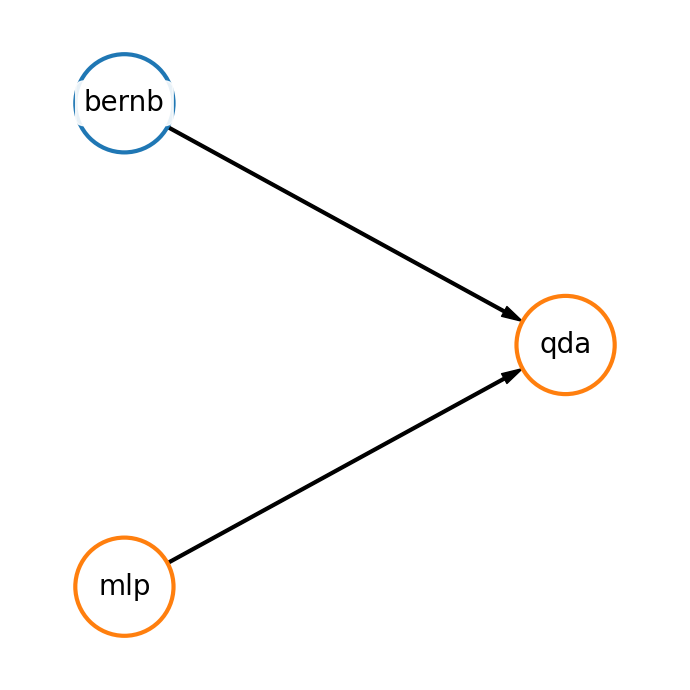

In [17]:
pipeline_evo_composed.show()

We got a pipeline of several machine learning models. But in the course of evolution, the hyperparameters of these models did not change. Now, within the given topology, we will optimize the hyperparameters.

In [18]:
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from golem.core.tuning.simultaneous import SimultaneousTuner
from fedot.core.repository.quality_metrics_repository import  ClassificationMetricsEnum


tuner = TunerBuilder(input_data.task)\
        .with_tuner(SimultaneousTuner)\
        .with_metric(ClassificationMetricsEnum.ROCAUC)\
        .with_iterations(20) \
        .build(input_data)
tuned_pipeline = tuner.tune(pipeline_evo_composed)

#final fit on all data
tuned_pipeline.fit(input_data)
print('Pipeline tuned')

INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-10-02 19:37:44,552 - DataSourceSplitter - Hold out validation is applied.


INFO:root:SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


2023-10-02 19:37:44,556 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


2023-10-02 19:37:44,559 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:44,571 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:44,573 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:44,574 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:44,582 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:44,874 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:44,876 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:44,877 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:44,881 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.884,)


2023-10-02 19:37:44,887 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.884,)


CRITICAL:root:SimultaneousTuner - Initial graph: {'depth': 2, 'length': 3, 'nodes': [qda, bernb, mlp]}
qda - {}
bernb - {}
mlp - {} 
Initial metric: [0.884]


2023-10-02 19:37:44,891 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 3, 'nodes': [qda, bernb, mlp]}
qda - {}
bernb - {}
mlp - {} 
Initial metric: [0.884]


CRITICAL:root:SimultaneousTuner - Graph "{'depth': 2, 'length': 3, 'nodes': [qda, bernb, mlp]}" has no parameters to optimize


2023-10-02 19:37:44,894 - SimultaneousTuner - Graph "{'depth': 2, 'length': 3, 'nodes': [qda, bernb, mlp]}" has no parameters to optimize


INFO:root:SimultaneousTuner - Hyperparameters optimization finished


2023-10-02 19:37:44,899 - SimultaneousTuner - Hyperparameters optimization finished


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


2023-10-02 19:37:44,906 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda fit started


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:44,919 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:44,922 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:44,923 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:44,931 - PipelineNode - Trying to fit pipeline node with operation: mlp


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:45,168 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:45,170 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:45,171 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:45,174 - PipelineNode - Obtain prediction in pipeline node by operation: mlp


DEBUG:root:PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.884,)


2023-10-02 19:37:45,180 - PipelineObjectiveEvaluate - Pipeline (/n_bernb;;/n_mlp;)/n_qda with evaluated metrics: (-0.884,)


INFO:root:SimultaneousTuner - Return init graph due to the fact that obtained metric 0.884 worse than initial (+ 0.05% deviation) 0.884


2023-10-02 19:37:45,183 - SimultaneousTuner - Return init graph due to the fact that obtained metric 0.884 worse than initial (+ 0.05% deviation) 0.884


CRITICAL:root:SimultaneousTuner - Final graph: {'depth': 2, 'length': 3, 'nodes': [qda, bernb, mlp]}
qda - {}
bernb - {}
mlp - {}


2023-10-02 19:37:45,184 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 3, 'nodes': [qda, bernb, mlp]}
qda - {}
bernb - {}
mlp - {}


CRITICAL:root:SimultaneousTuner - Final metric: 0.884


2023-10-02 19:37:45,186 - SimultaneousTuner - Final metric: 0.884


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: qda


2023-10-02 19:37:45,197 - PipelineNode - Trying to fit pipeline node with operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:45,199 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: bernb


2023-10-02 19:37:45,200 - PipelineNode - Trying to fit pipeline node with operation: bernb


DEBUG:root:PipelineNode - Trying to fit pipeline node with operation: mlp


2023-10-02 19:37:45,206 - PipelineNode - Trying to fit pipeline node with operation: mlp
Pipeline tuned


Check the metric

In [19]:
prediction = tuned_pipeline.predict(input_data)
print(f'ROC AUC score on training sample: {roc_auc(input_data.target, prediction.predict):.3f}')

DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: qda


2023-10-02 19:37:45,532 - PipelineNode - Obtain prediction in pipeline node by operation: qda


DEBUG:root:PipelineNode - Fit all parent nodes in secondary node with operation: qda


2023-10-02 19:37:45,534 - PipelineNode - Fit all parent nodes in secondary node with operation: qda


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: bernb


2023-10-02 19:37:45,536 - PipelineNode - Obtain prediction in pipeline node by operation: bernb


DEBUG:root:PipelineNode - Obtain prediction in pipeline node by operation: mlp


2023-10-02 19:37:45,539 - PipelineNode - Obtain prediction in pipeline node by operation: mlp
ROC AUC score on training sample: 0.947


As you can see from the metric value, the model was well trained on the training sample. 

### Pipeline visualistion 

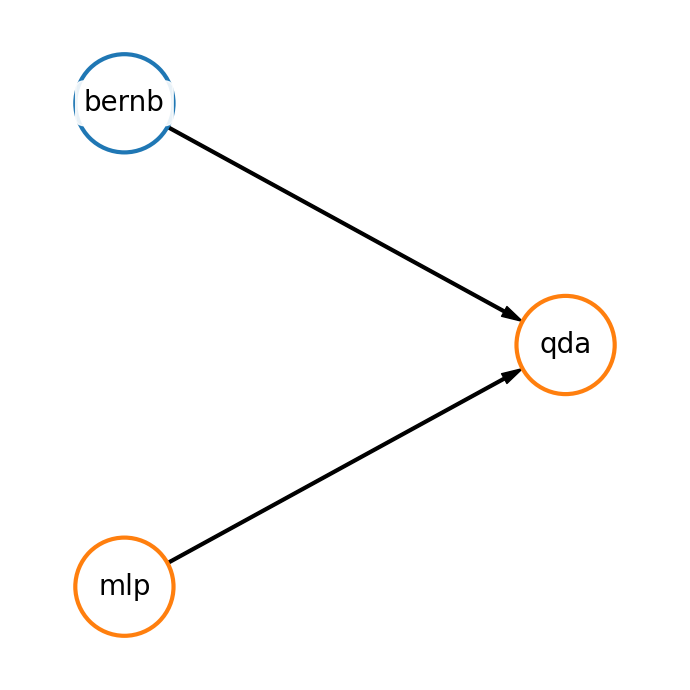

In [20]:
tuned_pipeline.show()

So, in this notebook, you learned how to run FEDOT for the classification task, both using the API and using more complex constructs from the core based on the functionality of the FEDOT framework.